##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neuron Groups -- Building Blocks of Interpretability

This colab notebook is part of our **Building Blocks of Intepretability** series exploring how intepretability techniques combine together to explain neural networks. If you haven't already, make sure to look at the [**corresponding paper**](https://distill.pub/2018/building-blocks) as well!

This notebook demonstrates **Neuron Groups**, a technique for exploring how detectors a different spatial positions in the network effected its output.

<br>

<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/neuron-groups.jpeg" width="648"></img>

<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!


# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [12]:
#!pip install --quiet lucid==0.0.5
#!npm install -g svelte-cli@2.2.0

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map

/glade/work/molina/miniconda3/envs/python-tf1/bin/svelte -> /glade/work/molina/miniconda3/envs/python-tf1/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
added 2 packages from 1 contributor in 1.326s


# Attribution & UI Code

In [2]:
model = models.InceptionV1()
model.load_graphdef()

In [4]:
model

In [5]:
labels_str = read("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt")

In [9]:
labels = [line[line.find(" "):].strip() for line in labels_str.decode().split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [10]:
labels

['dummy',
 'kit fox',
 'English setter',
 'Siberian husky',
 'Australian terrier',
 'English springer',
 'grey whale',
 'lesser panda',
 'Egyptian cat',
 'ibex',
 'Persian cat',
 'cougar',
 'gazelle',
 'porcupine',
 'sea lion',
 'malamute',
 'badger',
 'Great Dane',
 'Walker hound',
 'Welsh springer spaniel',
 'whippet',
 'Scottish deerhound',
 'killer whale',
 'mink',
 'African elephant',
 'Weimaraner',
 'soft-coated wheaten terrier',
 'Dandie Dinmont',
 'red wolf',
 'Old English sheepdog',
 'jaguar',
 'otterhound',
 'bloodhound',
 'Airedale',
 'hyena',
 'meerkat',
 'giant schnauzer',
 'titi',
 'three-toed sloth',
 'sorrel',
 'black-footed ferret',
 'dalmatian',
 'black-and-tan coonhound',
 'papillon',
 'skunk',
 'Staffordshire bullterrier',
 'Mexican hairless',
 'Bouvier des Flandres',
 'weasel',
 'miniature poodle',
 'Cardigan',
 'malinois',
 'bighorn',
 'fox squirrel',
 'colobus',
 'tiger cat',
 'Lhasa',
 'impala',
 'coyote',
 'Yorkshire terrier',
 'Newfoundland',
 'brown bear',
 '

In [13]:
%%html_define_svelte GroupWidget

<div class="figure" style="width: 600px;">
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <img src="{{img}}">
    {{#if pres_n != undefined}}
    <img src="{{spatial_factors[pres_n]}}" class="overlay"  >
    {{/if}}
  </div>
   
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <div style="width:100%; height: 100%; background-color: #000;"></div>
    {{#each range(n_groups) as n}}
    {{#if pres_n == undefined || pres_n == n}}
    <img src="{{spatial_factors[n]}}" class="factor" 
         style="filter: hue-rotate({{n*360/n_groups}}deg);">
    {{/if}}
    {{/each}}
  </div>
  
  <br>
  <br>
  
  <div on:mouseleave="set({pres_n: undefined})">
    {{#each range(n_groups) as n}}
    <div class="group" style="background-color: hsl({{n*360/n_groups}}, 80%, 50%); "
         on:mouseover="set({pres_n: n})">
      <img src="{{group_icons[n]}}">
    </div>
    {{/each}}
  </div>
  
</div>


<style>
  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .factor {
    mix-blend-mode: lighten;
  }
  .overlay {
    filter: grayscale(100%) brightness(3);
    mix-blend-mode: multiply;
  }
  .group {
    width: 80px;
    height: 80px;
    margin-right: 4px;
    display: inline-block;
    padding-top: 10px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        n_groups: 1,
        spatial_factors: [""],
        group_icons: [""],
        pres_n: undefined,
        
      };
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /glade/scratch/molina/svelte_gl2g59uw/GroupWidget_285a703f_a9e9_440c_8410_3980de0c3be0.html > /glade/scratch/molina/svelte_gl2g59uw/GroupWidget_285a703f_a9e9_440c_8410_3980de0c3be0.js
b'svelte version 1.64.1\ncompiling ../../../../../../../scratch/molina/svelte_gl2g59uw/GroupWidget_285a703f_a9e9_440c_8410_3980de0c3be0.html...\n(4:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(6:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(14:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(27:6) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n'


In [14]:
def raw_class_group_attr(img, layer, label, group_vecs, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Compute activations
    acts = T(layer).eval()
    
    if label is None: return np.zeros(acts.shape[1:-1])
    
    # Compute gradient
    score = T("softmax2_pre_activation")[0, labels.index(label)]
    t_grad = tf.gradients([score], [T(layer)])[0]   
    grad = t_grad.eval({T(layer) : acts})
    
    # Linear approximation of effect of spatial position
    return [np.sum(group_vec * grad) for group_vec in group_vecs]

In [16]:
def neuron_groups(img, layer, n_groups=6, attr_classes=[]):

  # Compute activations

  with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval()

  # We'll use ChannelReducer (a wrapper around scikit learn's factorization tools)
  # to apply Non-Negative Matrix factorization (NMF).

  nmf = ChannelReducer(n_groups, "NMF")
  spatial_factors = nmf.fit_transform(acts)[0].transpose(2, 0, 1).astype("float32")
  channel_factors = nmf._reducer.components_.astype("float32")

  # Let's organize the channels based on their horizontal position in the image

  x_peak = np.argmax(spatial_factors.max(1), 1)
  ns_sorted = np.argsort(x_peak)
  spatial_factors = spatial_factors[ns_sorted]
  channel_factors = channel_factors[ns_sorted]

  # And create a feature visualziation of each group

  param_f = lambda: param.image(80, batch=n_groups)
  obj = sum(objectives.direction(layer, channel_factors[i], batch=i)
            for i in range(n_groups))
  group_icons = render.render_vis(model, obj, param_f, verbose=False)[-1]
  
  # We'd also like to know about attribution
  
  # First, let's turn each group into a vector over activations
  group_vecs = [spatial_factors[i, ..., None]*channel_factors[i]
                for i in range(n_groups)]
  
  attrs = np.asarray([raw_class_group_attr(img, layer, attr_class, group_vecs)
                     for attr_class in attr_classes])
  
  print(attrs)
  
  # Let's render the visualization!
  
  lucid_svelte.GroupWidget({
    "img" : _image_url(img),
    "n_groups": n_groups,
    "spatial_factors": [_image_url(factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]) for factor in spatial_factors], 
    "group_icons": [_image_url(icon) for icon in group_icons] 
  })
  
  

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


[[ 3.7463198   3.7567778  -1.1973733   0.714411   -0.5310481  -2.1201746 ]
 [-0.5055699  -0.31257564 -1.9789618   0.6788019   1.1792585   0.7690112 ]]



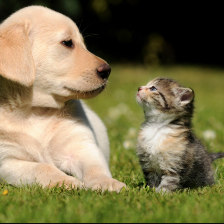
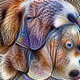
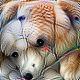
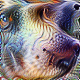
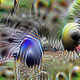
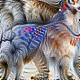
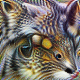

In [17]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
neuron_groups(img, "mixed4d", 6, ["Labrador retriever", "tiger cat"])

[]



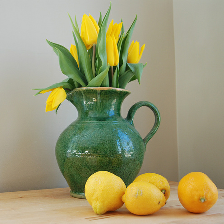
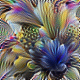
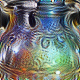
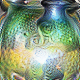
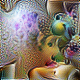
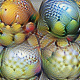

In [18]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/flowers.png")
neuron_groups(img, "mixed4d", 5)

In [22]:
from platform import python_version

print(python_version())

3.7.3
